# DEHP ALTERNATIVES ANALYSIS

## Get Modelable Properties

In [ ]:
import sys, os, pandas as pd, sqlite3, pathlib
from tqdm import tqdm
from git import Repo

# change directory to git root and add it to path
os.chdir(Repo("./", search_parent_directories=True).git.rev_parse("--show-toplevel"))
sys.path.append('./')
from flask_cvae.predictor import Predictor

tqdm.pandas()

predictor : Predictor = Predictor((repo_root / 'flask_cvae/predictions.sqlite').as_posix())
def build_propdf():
    conn = sqlite3.connect('brick/cvae.sqlite')
    proptitle = pd.read_sql("SELECT property_token,title FROM property p", conn).groupby('property_token').first().reset_index()
    propdf = predictor._get_all_properties().groupby('property_token').first().reset_index()\
        .merge(proptitle, on='property_token', how='inner')

    return propdf\
        .query('category != "kinetics (pharmacokinetics, toxicokinetics, adme, cmax, auc, etc)"')\
        .query('category != "chemical physical property"')\
        .rename(columns={'strength':'category_strength', 'title':'property_title','value':'known_value'})

propdf = build_propdf()
propdf

,property_token,source,data,category,reason,category_strength,property_title
1,2432,pubchem,"{""BioAssay Name"": ""qHTS for Inhibitors of huma...",genotoxicity,This assay is for human tyrosyl-DNA phosphodie...,8.0,[inhibition of human tyrosyl-dna phosphodieste...
2,2433,pubchem,"{""BioAssay Name"": ""qHTS for Inhibitors of huma...",genotoxicity,The assay is for inhibitors of human tyrosyl-D...,7.0,assay for inhibitors of human tyrosyl-dna phos...
3,2434,pubchem,"{""BioAssay Name"": ""MLPCN Alpha-Synuclein 5'UTR...",neurotoxicity,The assay involves Alpha-Synuclein 5'UTR which...,8.0,mlpcn alpha-synuclein 5'utr screening for smal...
4,2435,pubchem,"{""BioAssay Name"": ""qHTS Assay for Inhibitors o...",genotoxicity,This assay is for a histone lysine methyltrans...,7.0,assay for inhibitors of histone lysine methylt...
5,2436,pubchem,"{""BioAssay Name"": ""Cycloheximide Counterscreen...",neurotoxicity,The assay is screening for inhibitors of Shiga...,7.0,small molecule inhibitors assay for shiga toxi...
...,...,...,...,...,...,...,...
3788,6219,ice,"{""Assay"": ""hCLAT"", ""Endpoint"": ""CD86, Call"", ""...",skin sensitization,The hCLAT assay is designed to predict skin se...,10.0,chemical immunotoxicity assessment via cd86 ex...
3789,6220,bindingdb,"{""BindingDB Target Chain Sequence"": ""MDYQVSSPI...",immunotoxicity,"The target of the assay, C-C chemokine recepto...",9.0,assay for c-c chemokine receptor type 5 inhibi...
3793,6224,bindingdb,"{""BindingDB Target Chain Sequence"": ""MTMTLHTKA...",endocrine disruption,The assay under discussion is for the Estrogen...,10.0,assay for estrogen receptor y537s mutation tar...
3794,6225,ice,"{""Assay"": ""BSK_BT_sIgG_down"", ""Endpoint"": ""Cal...",immunotoxicity,The mention of sIgG_down in the assay indicate...,8.0,chemical suppression assay for borrelia-specif...


## Get alternatives & join properties

In [3]:

dehp = "InChI=1S/C24H38O4/c1-5-9-13-19(7-3)17-27-23(25)21-15-11-12-16-22(21)24(26)28-18-20(8-4)14-10-6-2/h11-12,15-16,19-20H,5-10,13-14,17-18H2,1-4H3"
alternatives = {
    'Di(2-ethylhexyl) phthalate': dehp,
    'Diisononyl phthalate':                     "InChI=1S/C26H42O4/c1-21(2)15-9-5-7-13-19-29-25(27)23-17-11-12-18-24(23)26(28)30-20-14-8-6-10-16-22(3)4/h11-12,17-18,21-22H,5-10,13-16,19-20H2,1-4H3",
    'Diisodecyl phthalate':                     "InChI=1S/C28H46O4/c1-23(2)17-11-7-5-9-15-21-31-27(29)25-19-13-14-20-26(25)28(30)32-22-16-10-6-8-12-18-24(3)4/h13-14,19-20,23-24H,5-12,15-18,21-22H2,1-4H3",
    'Dioctyl terephthalate':                    "InChI=1S/C24H38O4/c1-3-5-7-9-11-13-19-27-23(25)21-15-17-22(18-16-21)24(26)28-20-14-12-10-8-6-4-2/h15-18H,3-14,19-20H2,1-2H3",
    'Acetyl tributyl citrate':                  "InChI=1S/C20H34O8/c1-5-8-11-25-17(22)14-20(28-16(4)21,19(24)27-13-10-7-3)15-18(23)26-12-9-6-2/h5-15H2,1-4H3",
    'Trioctyl trimellitate':                    "InChI=1S/C33H54O6/c1-7-13-16-25(10-4)22-37-31(34)28-19-20-29(32(35)38-23-26(11-5)17-14-8-2)30(21-28)33(36)39-24-27(12-6)18-15-9-3/h19-21,25-27H,7-18,22-24H2,1-6H3",
    'Diisononyl cyclohexane-1,2-dicarboxylate': "InChI=1S/C26H48O4/c1-21(2)15-9-5-7-13-19-29-25(27)23-17-11-12-18-24(23)26(28)30-20-14-8-6-10-16-22(3)4/h21-24H,5-20H2,1-4H3",
    'Butyryl trihexyl citrate':                 "InChI=1S/C28H50O8/c1-5-9-12-15-19-33-25(30)22-28(36-24(29)18-8-4,27(32)35-21-17-14-11-7-3)23-26(31)34-20-16-13-10-6-2/h5-23H2,1-4H3",
    'Di(2-ethylhexyl) terephthalate':           "InChI=1S/C24H38O4/c1-5-9-11-19(7-3)17-27-23(25)21-13-15-22(16-14-21)24(26)28-18-20(8-4)12-10-6-2/h13-16,19-20H,5-12,17-18H2,1-4H3",
    "BenzoPhenone-4": "InChI=1S/C14H12O6S/c1-20-12-8-11(15)10(7-13(12)21(17,18)19)14(16)9-5-3-2-4-6-9/h2-8,15H,1H3,(H,17,18,19)"
}

# make alternatives df `altdf` and generate thousands of predictions
altdf = pd.DataFrame(alternatives.items(), columns=['name','inchi'])
altdf = altdf.assign(key=1).merge(propdf.assign(key=1), on='key').drop('key', axis=1)
altdf['prediction'] = altdf.progress_apply(lambda x: predictor.cached_predict_property(x['inchi'], x['property_token']), axis=1)

# # get the known values from our databases
known_dfs = []
for inchi in altdf['inchi'].unique():
    df = pd.DataFrame(predictor._get_known_properties(inchi))[['inchi','property_token','value']]
    known_dfs.append(df)
knowndf = pd.concat(known_dfs)

# put alternatives, predictions, and known values together
altdf = altdf.merge(knowndf, on=['inchi','property_token'], how='left').drop_duplicates()
altdf['value'] = altdf['value'].fillna('unknown')

# show it to us
altdf[['name','category','category_strength','property_title','value','prediction']]


100%|██████████| 13690/13690 [00:00<00:00, 61939.50it/s]


,name,category,category_strength,property_title,value,prediction
0,Di(2-ethylhexyl) phthalate,genotoxicity,8.0,[inhibition of human tyrosyl-dna phosphodiesterase 1 by small molecules in the presence of cpt],negative,0.128230
9,Di(2-ethylhexyl) phthalate,genotoxicity,7.0,assay for inhibitors of human tyrosyl-dna phosphodiesterase 1,negative,0.133205
18,Di(2-ethylhexyl) phthalate,neurotoxicity,8.0,mlpcn alpha-synuclein 5'utr screening for small-molecule activators,unknown,0.005881
19,Di(2-ethylhexyl) phthalate,genotoxicity,7.0,assay for inhibitors of histone lysine methyltransferase g9a,negative,0.026195
23,Di(2-ethylhexyl) phthalate,neurotoxicity,7.0,small molecule inhibitors assay for shiga toxin counteraction,unknown,0.021520
...,...,...,...,...,...,...
20492,BenzoPhenone-4,endocrine disruption,3.0,ledgf/p75-integrase multimerization activator assay,unknown,0.065899
20493,BenzoPhenone-4,immunotoxicity,8.0,[cell-based high throughput cytotoxicity assay for tlr9-myd88 binding inhibitors],unknown,0.053804
20494,BenzoPhenone-4,immunotoxicity,8.0,cho cell-based toxicity assay for tlr9-myd88 binding inhibitors,unknown,0.271776
20495,BenzoPhenone-4,hepatotoxicity,8.0,high throughput assay for hnf4 dimerization inhibition,unknown,0.054372


## What is model accuracy?

In [4]:
def compute_metrics(g):
    nprops = g['property_token'].nunique()
    numtrue = g['value'].sum()
    numfalse = len(g) - numtrue
    acc = sklearn.metrics.accuracy_score(g['value'], g['prediction'] > 0.5)
    return pd.Series({'accuracy': acc, 'numprops': nprops, 'numtrue': numtrue, 'numfalse': numfalse, 'numeval': len(g)})

# Group by 'inchi' and apply the metrics function
accdf = altdf.query('value in ["positive","negative"]').assign(value = altdf['value'] == 'positive')
accdf = accdf.query('category_strength > 8.0')
resdf = accdf.groupby(['category']).apply(compute_metrics)\
    .reset_index().sort_values('accuracy', ascending=False)

resdf

,category,accuracy,numprops,numtrue,numfalse,numeval
0,acute inhalation toxicity,1.000000,2.0,0.0,14.0,14.0
1,acute oral toxicity,1.000000,4.0,2.0,17.0,19.0
7,flammability,1.000000,2.0,0.0,14.0,14.0
12,neurotoxicity,1.000000,5.0,0.0,5.0,5.0
9,hepatotoxicity,0.984000,27.0,2.0,123.0,125.0
8,genotoxicity,0.962264,9.0,3.0,50.0,53.0
6,endocrine disruption,0.961268,125.0,21.0,547.0,568.0
14,skin irritation,0.928571,2.0,1.0,13.0,14.0
3,carcinogenicity,0.905172,63.0,9.0,107.0,116.0
10,mutagenicity,0.900000,3.0,1.0,9.0,10.0


## Which alts are most active?

In [5]:
# start by creating analysis dataframe `adf` with `likely_active` definition
relevant_hazards = ['reproductive toxicity','endocrine disruption','mutagenicity','developmental toxicity','genotoxicity']
adf = altdf\
    .assign(likely_active = altdf['prediction'] > 0.1)\
    .query(f'category in {relevant_hazards}')\
    .query(f'category_strength > 8.0')\
    .rename(columns={'title':'property_title','value':'known_value'})\
    [['name','property_title','category','known_value','prediction','likely_active']]\
    .drop_duplicates()
adf[['name','property_title','category','prediction','likely_active']]

,name,property_title,category,prediction,likely_active
148,Di(2-ethylhexyl) phthalate,high throughput screening for dna re-replication inducing molecules in colon cancer cells,genotoxicity,0.133478,True
182,Di(2-ethylhexyl) phthalate,ccris mutagenicity assay study,mutagenicity,0.008037,False
183,Di(2-ethylhexyl) phthalate,ccris mutagenicity assay study,mutagenicity,0.008037,False
200,Di(2-ethylhexyl) phthalate,assay for aromatase inhibition impact on viability,endocrine disruption,0.051148,False
201,Di(2-ethylhexyl) phthalate,estrogen receptor alpha antagonist assay (chapter 2),endocrine disruption,0.036840,False
...,...,...,...,...,...
20320,BenzoPhenone-4,estrogen receptor binding assays for chemical toxicology,endocrine disruption,0.014111,False
20321,BenzoPhenone-4,dsstox salmonella mutagenicity assay,mutagenicity,0.404009,True
20329,BenzoPhenone-4,[evaluation of antagonists of the thyroid stimulation hormone receptor through qhts],endocrine disruption,0.320251,True
20397,BenzoPhenone-4,validation of inhibitors of the vitamin d receptor using qhts beta-lactamase assay,endocrine disruption,0.006451,False


### Overall Hazard 

In [6]:
# OVERALL ACTIVITY
# we count which alts have the most likely_hazards
# ATBC is our overall least 'active' by a wide margin
# DEHP is 4th, and significantly worse than ATBC
# Dioctyl terephthalate is our overall most 'active'
count_activities = lambda x: pd.Series({'likely_activities': x['likely_active'].sum()})
adf.groupby('name').apply(count_activities).sort_values('likely_activities').reset_index()

,name,likely_activities
0,"Diisononyl cyclohexane-1,2-dicarboxylate",12
1,Butyryl trihexyl citrate,16
2,BenzoPhenone-4,17
3,Diisodecyl phthalate,19
4,Diisononyl phthalate,24
5,Di(2-ethylhexyl) phthalate,33
6,Di(2-ethylhexyl) terephthalate,34
7,Trioctyl trimellitate,40
8,Dioctyl terephthalate,42
9,Acetyl tributyl citrate,44


### Endocrine Disruption

In [7]:
# ENDOCRINE DISRUPTION
# which alts have the most endocrine likely hazards
# ATBC least active
# Dioctyl terephthalate worst in endocrine as well
adf.query('category == "endocrine disruption"')\
    .groupby(['name']).apply(count_activities).sort_values('likely_activities').reset_index()
    

,name,likely_activities
0,"Diisononyl cyclohexane-1,2-dicarboxylate",5
1,BenzoPhenone-4,9
2,Butyryl trihexyl citrate,9
3,Diisodecyl phthalate,11
4,Diisononyl phthalate,13
5,Di(2-ethylhexyl) phthalate,22
6,Di(2-ethylhexyl) terephthalate,23
7,Trioctyl trimellitate,29
8,Acetyl tributyl citrate,31
9,Dioctyl terephthalate,32


## Which properties have the most positives?

In [8]:
predsum = lambda x: pd.Series({'num_pos': (x['prediction'] > 0.5).sum()})

pprops = altdf[['source', 'property_title', 'category', 'category_strength', 'name', 'prediction']]\
    .query('category_strength > 8.0')\
    .drop_duplicates()\
    .groupby(['source', 'property_title', 'category']).apply(predsum)\
    .sort_values('num_pos', ascending=False)\
    .reset_index()

# pprops.query('category == "developmental toxicity"')
pprops.query('category == "endocrine disruption"')

,source,property_title,category,num_pos
12,chembl,assay for agonists of thyroid stimulating hormone receptor in human cell line,endocrine disruption,8
26,ice,tox21_err_antagonist call assay,endocrine disruption,4
33,pubchem,[evaluation of antagonists of the thyroid stimulation hormone receptor through qhts],endocrine disruption,2
38,ice,activity of chemical antagonists in tox21 assay,endocrine disruption,2
45,toxcast,erβ antagonist assay ratio in tox21,endocrine disruption,1
...,...,...,...,...
376,pubchem,estrogen receptor alpha antagonist assay using bg1 cell line,endocrine disruption,0
377,pubchem,er-beta cell-based assay for small molecule antagonists,endocrine disruption,0
378,pubchem,er-beta cell viability assay for tox21 project,endocrine disruption,0
379,pubchem,er-beta cell viability antagonist assay,endocrine disruption,0


# Visualize & Cluster Alternatives By Predicted Property

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_category(cat, thresh=0.1):
    pdf = altdf.query(f'category=="{cat}"').query('category_strength > 9')[['property_title','name','prediction']].drop_duplicates()
    # rebalance prediction around .1 so 0.0 goes to 0 and .1 goes to .5 and 1.0 stays at 1.0 with linear     
    pdf['prediction'] = pdf['prediction'].apply(lambda pred: pred / 0.2 if pred <= thresh else 0.5 + (pred - thresh) / 0.9 * 0.5)

    pdf['property_title'] = pdf['property_title'].map(lambda x: x[:50] if len(x) > 25 else x)
    heatmap_data = pdf.pivot_table(values='prediction', columns='name', index='property_title', fill_value=0)

    # Compute the cosine distance and perform hierarchical clustering
    row_dist = pdist(heatmap_data, metric='cosine')
    col_dist = pdist(heatmap_data.T, metric='cosine')

    row_linkage = linkage(row_dist, method='average')
    col_linkage = linkage(col_dist, method='average')

    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)

    # Reorder the data
    heatmap_data = heatmap_data.iloc[row_order, col_order]

    # Identify the column to highlight
    highlight_col = 'Di(2-ethylhexyl) phthalate'

    # Plot the heatmap
    plt.figure(figsize=(12, 12), facecolor='black')
    cmap = sns.diverging_palette(250, 10, s=75, l=40, n=3, center="dark", as_cmap=True)  # Adjusted palette to go from dark to red
    ax = sns.heatmap(heatmap_data, cmap=cmap, annot=False, square=True, fmt=".2f",
                    linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

        # Highlight the specific column with a semi-transparent gold overlay
    if highlight_col in heatmap_data.columns:
        highlight_index = list(heatmap_data.columns).index(highlight_col)
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_edgecolor('white')
        for tick_label in ax.get_xticklabels():
            if tick_label.get_text() == highlight_col:
                tick_label.set_color('yellow')
                tick_label.set_fontweight('bold')
        
        # Add a rectangle to highlight the column
        for y in range(len(heatmap_data)):
            ax.add_patch(Rectangle((highlight_index, y), 1, 1, fill=False, edgecolor='white'))


    # Set the tick labels color for row and column names
    ax.tick_params(axis='x', colors='white', rotation=45)
    ax.tick_params(axis='y', colors='white')

    # Set the axes background color to black
    ax.set_facecolor('black')

    # Adjust the x-axis label position
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

    # Improve the appearance of the colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Active Probability', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.ax.yaxis.set_ticklabels([f'{x:.2f}' for x in cbar.get_ticks()], color='white')

    # Show the plot with black background
    plt.show()



/tmp/ipykernel_2943872/4141998781.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.yaxis.set_ticklabels([f'{x:.2f}' for x in cbar.get_ticks()], color='white')


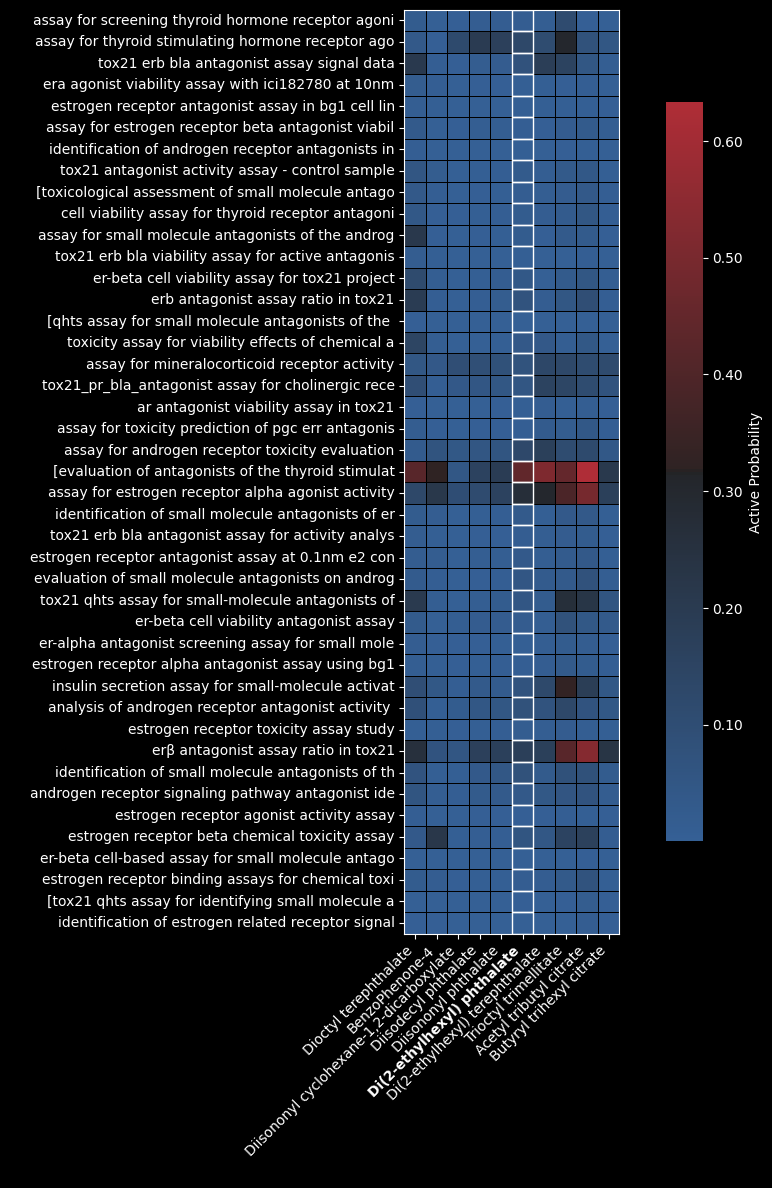

In [69]:
plot_category('endocrine disruption')